In [910]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Prepare Data

In [911]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [912]:
# save spectrum labels for later
spectrum_labels = spectrum_test.columns

In [913]:
# scale spectrum data
scale = 10**12
spectrum_train = spectrum_train.multiply(scale)
spectrum_test = spectrum_test.multiply(scale)

In [914]:
# determine direction and set train and test data
# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 1

if direction:
    X_train = temp_train
    X_test = temp_test
    y_train = spectrum_train
    y_test = spectrum_test
else:
    X_train = spectrum_train
    X_test = spectrum_test
    y_train = temp_train
    y_test = temp_test

In [915]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

In [916]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train)

In [917]:
n_samples, input_size = X.shape
_, output_size = y.shape

# Design Model 
(input size, output size, forward pass)

In [918]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 128)
        self.lin4 = nn.Linear(128, 128)
        self.lin5 = nn.Linear(128, 128)
        self.lin6 = nn.Linear(128, 128)
        self.lin7 = nn.Linear(128, 128)
        self.lin8 = nn.Linear(128, 128)
        self.lin9 = nn.Linear(128, 128)
        self.lin_fin = nn.Linear(128, output_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = F.leaky_relu(self.lin4(output))
        output = F.leaky_relu(self.lin5(output))
        output = F.leaky_relu(self.lin6(output))
        output = F.leaky_relu(self.lin7(output))
        output = F.leaky_relu(self.lin8(output))
        output = F.leaky_relu(self.lin9(output))
        output = self.lin_fin(output)
        return output

In [919]:
model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [920]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

# Training Loop

In [921]:
loss_list = []
num_epochs = 2000
for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    loss_list.append(loss)

    # backward pass
    loss.backward()

    # update
    optimizer.step()

    # empty gradients
    optimizer.zero_grad()

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

epoch: 200, loss = 0.1760
epoch: 400, loss = 0.0928
epoch: 600, loss = 0.0883
epoch: 800, loss = 0.0859
epoch: 1000, loss = 0.0848
epoch: 1200, loss = 0.0832
epoch: 1400, loss = 0.0838
epoch: 1600, loss = 0.0834
epoch: 1800, loss = 0.0831
epoch: 2000, loss = 0.0828


# Plots

In [922]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

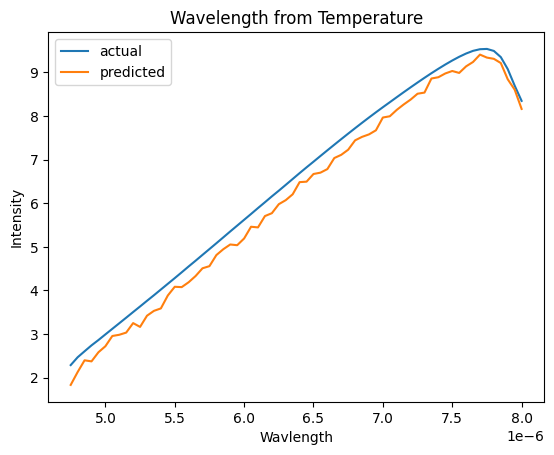

In [923]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(actual))

actual_np = actual.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np,  label='predicted')

if direction:
    plt.title("Wavelength from Temperature")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Temperature from Wavelength")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()

# Filter Data

In [924]:
from scipy.signal import savgol_filter

In [925]:
if direction:
    wl = 20
    p = 5
else:
    wl = 5
    p = 2

pred_filtered = savgol_filter(pred_np, window_length=wl, polyorder=p)

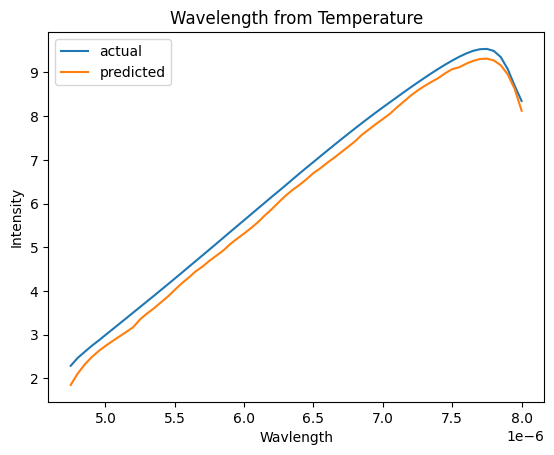

In [926]:
plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_filtered,  label='predicted')

if direction:
    plt.title("Wavelength from Temperature")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Temperature from Wavelength")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()